In [1]:
import fitz
from collections import Counter, defaultdict
import pandas as pd
import nltk
import glob
import os
import json
import stanza
import re
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import os

nlp = stanza.Pipeline('nl', processors = 'tokenize,lemma')

2021-02-28 14:12:12 INFO: Loading these models for language: nl (Dutch):
| Processor | Package |
-----------------------
| tokenize  | alpino  |
| lemma     | alpino  |

2021-02-28 14:12:12 INFO: Use device: cpu
2021-02-28 14:12:12 INFO: Loading: tokenize
2021-02-28 14:12:12 INFO: Loading: lemma
2021-02-28 14:12:12 INFO: Done loading processors!


In [2]:
#specify data paths, etc.

pdffolder = f'data'
stopwordspath = 'data/stopwords-nl.txt'

with open(stopwordspath, 'r', encoding = 'utf-8') as infile:
    stopwords = infile.read().split()
    
lemmas = True

### Text read functions

In [3]:
def import_texts(pdffolder):
    '''Import all texts from pdf-files in folder. Returns pandas Series containing texts.'''
    programmes = dict()
    for prog in glob.glob(f'{pdffolder}/*.pdf'):
        party_name = prog.split('\\')[1].split('.')[0]

        doc = fitz.open(prog)

        text = ''
        for n in range(doc.pageCount):
            text += doc.getPageText(n)
        programmes[party_name] = text
    return pd.Series(programmes)

def get_text(pdffile):
    '''Reads and returns text from pdffile.'''
    
    doc = fitz.open(pdffile)

    text = ''
    for n in range(doc.pageCount):
        text += doc.getPageText(n)
    return text

In [4]:
def filter_text(party, text):
    '''Filter headers/footers for 2021 election programmes. Returns filtered text.'''
    
    if party == '50PLUS':
        text = text.replace('De kracht van PLUS \nVerkiezingsprogramma 2021-', '')
        text = text.replace('•', '')
        
    elif party == 'CDA':
        text = text.replace('CDA-VERKIEZINGSPROGRAMMA 2021-Thuis\nNu doorpakken', '')
        text = text.replace('Nu doorpakken\nCDA-VERKIEZINGSPROGRAMMA 2021', '')
        text = text.replace('CDA-VERKIEZINGSPROGRAMMA 2021-2025', '')
        text = text.replace('CDA-VERKIEZINGSPROGRAMMA 2021', '')
        text = text.replace('\nNu doorpakken\n', '')
        text = text.replace('Christen-Democratisch Appèl', '')

    elif party == 'CU':
        text = text.replace('CHRISTENUNIE VERKIEZINGSPROGRAMMA 2021-2025', '')
        text = text.replace('\nKIEZEN  VOOR WAT ECHT TELT', '')
        text = text.replace('ChristenUnie', '')
        
    elif party == 'D66':
        text = text.replace('Verkiezingsprogramma 2021 - 2025                   \n  De digitale versie lees je op d66.nl/eennieuwbegin', '')
        text = text.replace('Een nieuw begin - Laat iedereen vrij, maar niemand vallen.', '')
        text = text.replace("Democraten '66", '')
        
    elif party == 'DENK':
        text = text.replace('Verkiezingsprogramma DENK 2021 – 2025', '')
        
    elif party == 'FVD':
        text = text.replace('FVD Verkiezingsprogramma 2021-2025', '')
        text = text.replace('Forum voor Democratie', '')
        
    elif party == 'GL':
        text = text.replace('VERKIEZINGSPROGRAMMA GROENLINKS 2021', '')
        text = text.replace('GROENLINKS', '')
        text = text.replace('GroenLinks', '')
        
    elif party == 'PvdA':
        text = text.replace('Verkiezingsprogramma PvdA 2021-2025', '')
        text = text.replace('•', '')
        text = text.replace('Partij van de Arbeid', '')
        
    elif party == 'PvdD':
        text = text.replace('VERKIEZINGSPROGRAMMA PARTIJ VOOR DE DIEREN TWEEDE KAMERVERKIEZINGEN 2021\nVERKIEZINGSPROGRAMMA PARTIJ VOOR DE DIEREN TWEEDE KAMERVERKIEZINGEN 202', '')
        text = text.replace('Partij voor de Dieren', '')
        
    elif party == 'PVV':
        text = text.replace('Het gaat om u\nVerkiezingsprogramma PVV 2021 - 2025', '')
        text = text.replace('Verkiezingsprogramma PVV 2021 - 2025\nHet gaat om u', '')
        text = text.replace('Partij voor de Vrijheid', '')
    
    #SGP hoeft niet te worden schoongemaakt (geen voettekst).
        
    elif party == 'SP':
        text = text.replace('VERKIEZINGSPROGRAMMA VAN DE SP 17 MAART 2021 STEL EEN DAAD', '')
        text = text.replace('Socialistische Partij', '')

    elif party == 'VVD':
        #hoofdstuktitels in voettekst
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Ons nieuwe verhaal', '')
        text = text.replace('▶', '')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Klimaat en Duurzaamheid','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Economie en Ondernemen','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Werk en Zekerheid','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Onderwijs en Vrijheid','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Volksgezondheid en Zorg','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Buitenland en Defensie','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Migratie en Integratie','')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Veiligheid', '')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Wonen en Vervoer', '')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Landbouw en Natuur', '')
        text = text.replace('Verkiezingsprogramma 2021 -2025  -  Overheid en Democratie', '')
        text = text.replace('Volkspartij voor Vrijheid en Democratie', '')        
        text = text.replace('Verkiezingsprogramma 2021 -2025', '')
        
    text = text.replace(party, '')
    
    for t in set(re.findall(' ?\n[0-9]+', text)):
        text = text.replace(t, '')
    for t in set(re.findall('[0-9]+ \n•?', text)):
        text = text.replace(t, '')
        
    for t in set(re.findall('[0-9]', text)):
        text = text.replace(t, '')
    
    return text

def filter_text17(party, text):
    '''Filter headers/footers for 2017 election programmes. Returns filtered text.'''
    
    party = party.replace('-2017', '')
    
    if party == 'CDA':
        text = text.replace('CDA VERKIEZINGSPROGRAM 2017-2021', '')
        text = text.replace('Christen-Democratisch Appèl', '')
        
    if party == 'CU':
        text = text.replace('Verkiezingsprogramma 2017-2021', '')
        text = text.replace('ChristenUnie', '')
        
    if party == 'D66':
        text = text.replace("Democraten '66", '')
        
    if party == 'DENK':
        text = text.replace('verkiezingsprogramma 2017-2021', '')
        text = text.replace('Verkiezingsprogramma DENK 2017-2021', '')
        
    if party == 'FVD':
        text = text.replace('Forum voor Democratie', '')
        
    if party == 'GL':
        text = text.replace('GROENLINKS', '')
        text = text.replace('GroenLinks', '')    
        
    if party == 'PvdA':
        text = text.replace('•', '')
        text = text.replace('EEN VERBONDEN SAMENLEVING', '')
        text = text.replace('Partij van de Arbeid', '')
    
    if party == 'PvdD':
        text = text.replace('Verkiezingsprogramma Partij voor de Dieren Tweede Kamerverkiezingen 2017', '')
        text = text.replace('Partij voor de Dieren', '')
        
    if party == 'PVV':
        text = text.replace('CONCEPT - VERKIEZINGSPROGRAMMA PW 2017', '')
        text = text.replace('Partij voor de Vrijheid', '')
    
    if party == 'SP':
        text = text.replace('PROGRAMMA VOOR EEN SOCIAAL NEDERLAND', '')
        text = text.replace('Socialistische Partij', '')
        
    if party == 'VVD':
        text = text.replace('■', '')
        text = text.replace('Volkspartij voor Vrijheid en Democratie', '')   
         
    text = text.replace(party, '')
    
    for t in set(re.findall(' ?\n[0-9]+', text)):
        text = text.replace(t, '')
    for t in set(re.findall('[0-9]+ \n•?', text)):
        text = text.replace(t, '')
        
    for t in set(re.findall('[0-9]', text)):
        text = text.replace(t, '')
    
    return text

### Frequency analysis

In [5]:
def count_words_in_text(pdfpath, stopwords):
    '''Reads text in pdf file and counts words, except stopwords.    
    Returns frequency dict of all lemmas in the text.'''
    doc = fitz.open(pdfpath)

    text = ''
    for n in range(doc.pageCount):
        text += doc.getPageText(n)

    with open(stopwordspath, 'r', encoding = 'utf-8') as infile:
        stopwords = infile.read().split()

    words = [w.lower() for w in nltk.word_tokenize(text) if w.lower() not in stopwords and w.isalpha() and len(w) > 1]
    counter = dict(Counter(words))
    return counter


def count_lemmas_in_text(party, pdfpath, stopwords, histo = False):
    '''Reads text in pdf file. Filters text and counts lemmas in filtered text, except stopwords.
    If histo == True, uses filter for 2017 texts.
    
    Returns frequency dict of all lemmas in the text.'''
    
    doc = fitz.open(pdfpath)

    if histo == False:
        text = filter_text(party, get_text(pdfpath))
    else:
        text = filter_text17(party, get_text(pdfpath))
        
    document = nlp(text)
    lemmas = [w.lower() for w in document.get('lemma') if w.isalpha() and len(w) > 1 and w.lower() not in stopwords]
    counter = dict(Counter(lemmas))
    return counter

def analyze_programs(pdffolder, stopwords, lemmas = True, histo = False):
    '''Wrapper function. Counts lemmas for every pdf file in pdffolder, except stopwords.
    Returns: pd.DataFrame allemaal: counted lemmas for every text.
    Returns: pd.DataFrame allemaal_totaal: counted lemmas for every text, including totals.
    Returns: pd.DataFrame fractions_df: relative frequency of lemma (promille)
    '''
    
    dfs = []
    fraction_dfs = []
    for prog in glob.glob(f'{pdffolder}/*.pdf'):
        party_name = prog.split('\\')[1].split('.')[0]
        print('processing party:', party_name)
        if lemmas:
            counter = count_lemmas_in_text(party_name, prog, stopwords, histo)
        else:
            counter = count_words_in_text(prog, stopwords)
        df = pd.DataFrame.from_dict(counter, orient = 'index')
        if party_name.endswith('17'):
            df.columns = [f'{party_name[:-5]}']
        else:
            df.columns = [f'{party_name}']
        dfs.append(df)
        
        #compute relative frequencies
        fractions = dict()
        wordcount = df.sum()
        for word, count in counter.items():
            fractions[word] = count / wordcount * 1000
        fraction_dfs.append(pd.DataFrame.from_dict(fractions, orient = 'index'))

    allemaal = pd.concat(dfs, axis = 1)
    allemaal = allemaal.round(0).fillna(0)

    word_freqs = pd.DataFrame(allemaal.sum(axis = 1), columns = ['Totaal'])
    word_totals = allemaal.sum(axis = 0)
    
    
    fractions_df = pd.concat(fraction_dfs, axis=1)
    fractions_df = fractions_df.fillna(0)

    allemaal_totaal = pd.concat([allemaal, word_freqs], axis = 1).round(0)
    fractions_df = fractions_df.round(4)
    return allemaal, allemaal_totaal, fractions_df

In [6]:
allemaal, allemaal_totaal, fractions = analyze_programs(pdffolder, stopwords, lemmas = lemmas)

processing party: 50PLUS
processing party: CDA
processing party: CU
processing party: D66
processing party: DENK
processing party: FVD
processing party: GL
processing party: PvdA
processing party: PvdD
processing party: PVV
processing party: SGP
processing party: SP
processing party: VVD


### Cosine similarity

In [7]:
def compute_cosine(frequencies):
    '''Computes and returns cosine frequency for every ith and jth column in the frequency table.'''
    
    correl = defaultdict(dict)
    covered = []

    for party1 in frequencies.columns:
        for party2 in frequencies.columns:
            zuiver1 = dict()
            zuiver2 = dict()
            terms1 = frequencies[party1].to_dict()
            terms2 = frequencies[party2].to_dict()
            
            #only consider terms in one of the two texts we're comparing
            for word, freq in terms1.items():
                if freq + terms2[word] > 0:
                    zuiver1[word] = freq
                    zuiver2[word] = terms2[word]

            zuiver1 = pd.Series(zuiver1)
            zuiver1.name = party1
            zuiver2 = pd.Series(zuiver2)
            zuiver2.name = party2
            
            c = cosine_similarity([zuiver1], [zuiver2])
            #print(party1, party2, c)
            correl[party1][party2] = c[0][0]

        covered.append(party1)

    return (pd.DataFrame.from_dict(correl).T.round(3)*100).convert_dtypes()


In [8]:
cosy = compute_cosine(allemaal)

In [9]:
cosy

,50PLUS,CDA,CU,D66,DENK,FVD,GL,PvdA,PvdD,PVV,SGP,SP,VVD
50PLUS,100.0,66.4,75.1,72.8,65.3,58.8,68.0,72.2,66.4,58.4,72.2,64.0,69.4
CDA,66.4,100.0,86.5,86.0,69.9,66.7,80.7,81.8,67.7,61.6,81.2,69.1,80.7
CU,75.1,86.5,100.0,92.5,77.6,71.6,87.4,90.2,78.6,66.8,91.7,76.4,87.7
D66,72.8,86.0,92.5,100.0,76.6,72.5,90.1,90.6,78.3,67.4,88.3,76.3,89.0
DENK,65.3,69.9,77.6,76.6,100.0,67.4,75.7,77.2,66.0,68.2,73.8,67.8,76.0
FVD,58.8,66.7,71.6,72.5,67.4,100.0,68.6,70.4,62.7,69.7,71.6,60.2,73.8
GL,68.0,80.7,87.4,90.1,75.7,68.6,100.0,89.5,78.0,67.1,81.0,81.4,83.3
PvdA,72.2,81.8,90.2,90.6,77.2,70.4,89.5,100.0,77.8,68.5,84.5,81.4,83.4
PvdD,66.4,67.7,78.6,78.3,66.0,62.7,78.0,77.8,100.0,64.0,74.7,68.0,75.1
PVV,58.4,61.6,66.8,67.4,68.2,69.7,67.1,68.5,64.0,100.0,67.9,64.2,73.2


### History lesson

In [10]:
#Generate frequency tables for 2017 election programmes
histo, histo_totaal, histo_frac = analyze_programs(f'{pdffolder}/2017', stopwords, lemmas = lemmas, histo = True)

#Compute cosine similarity for 2017 programmes
cosy_h = compute_cosine(histo)

processing party: 50PLUS-2017
processing party: CDA-2017
processing party: CU-2017
processing party: D66-2017
processing party: DENK-2017
processing party: FVD-2017
processing party: GL-2017
processing party: PvdA-2017
processing party: PvdD-2017
processing party: PVV-2017
processing party: SGP-2017
processing party: SP-2017
processing party: VVD-2017


In [11]:
cosy_h

,50PLUS,CDA,CU,D66,DENK,FVD,GL,PvdA,PvdD,PVV,SGP,SP,VVD
50PLUS,100.0,64.1,65.0,63.6,51.5,56.5,60.0,63.5,54.6,21.5,64.5,58.6,62.6
CDA,64.1,100.0,88.4,86.0,73.3,66.8,76.5,86.1,65.4,23.5,83.1,76.2,84.2
CU,65.0,88.4,100.0,89.4,71.1,69.1,83.0,89.3,73.1,23.6,88.1,80.9,86.0
D66,63.6,86.0,89.4,100.0,70.7,71.1,84.2,88.1,73.7,25.4,85.4,80.1,90.3
DENK,51.5,73.3,71.1,70.7,100.0,57.2,66.7,72.2,59.5,28.6,64.7,60.8,69.1
FVD,56.5,66.8,69.1,71.1,57.2,100.0,64.7,68.9,59.7,27.9,72.1,65.1,73.1
GL,60.0,76.5,83.0,84.2,66.7,64.7,100.0,83.7,76.8,26.8,79.0,80.7,79.4
PvdA,63.5,86.1,89.3,88.1,72.2,68.9,83.7,100.0,72.1,23.9,82.7,82.9,84.4
PvdD,54.6,65.4,73.1,73.7,59.5,59.7,76.8,72.1,100.0,24.8,72.1,71.3,71.0
PVV,21.5,23.5,23.6,25.4,28.6,27.9,26.8,23.9,24.8,100.0,26.5,25.0,27.2


## Consistency

In [12]:
#Compute consistency by computing cosine similarity between a party's programme in 2021 and 2017.

histo = histo_totaal.drop('Totaal', axis=1)

selfcorr = dict()

for party in allemaal.columns:
    nu = allemaal[party]
    toen = histo[party]
    samen = pd.concat([nu, toen], axis = 1)
    samen.columns = ['nu', 'toen']
    samen.fillna(0, inplace = True)
    selfcorr[party] = cosine_similarity([samen['nu']], [samen['toen']])[0][0] * 100

consistency = pd.DataFrame.from_dict(selfcorr, orient = 'index', columns = ['Consistentie']).round(2)
consistency.sort_values(by = 'Consistentie', ascending = False)

,Consistentie
SGP,94.31
D66,93.31
CU,93.17
PvdD,92.57
PvdA,89.25
VVD,88.09
CDA,87.06
GL,86.97
SP,84.79
FVD,79.85


In [13]:
transitions = pd.DataFrame((cosy - cosy_h), columns = cosy_h.columns, index = cosy_h.index)

transitions

,50PLUS,CDA,CU,D66,DENK,FVD,GL,PvdA,PvdD,PVV,SGP,SP,VVD
50PLUS,0.0,2.3,10.1,9.2,13.8,2.3,8.0,8.7,11.8,36.9,7.7,5.4,6.8
CDA,2.3,0.0,-1.9,0.0,-3.4,-0.1,4.2,-4.3,2.3,38.1,-1.9,-7.1,-3.5
CU,10.1,-1.9,0.0,3.1,6.5,2.5,4.4,0.9,5.5,43.2,3.6,-4.5,1.7
D66,9.2,0.0,3.1,0.0,5.9,1.4,5.9,2.5,4.6,42.0,2.9,-3.8,-1.3
DENK,13.8,-3.4,6.5,5.9,0.0,10.2,9.0,5.0,6.5,39.6,9.1,7.0,6.9
FVD,2.3,-0.1,2.5,1.4,10.2,0.0,3.9,1.5,3.0,41.8,-0.5,-4.9,0.7
GL,8.0,4.2,4.4,5.9,9.0,3.9,0.0,5.8,1.2,40.3,2.0,0.7,3.9
PvdA,8.7,-4.3,0.9,2.5,5.0,1.5,5.8,0.0,5.7,44.6,1.8,-1.5,-1.0
PvdD,11.8,2.3,5.5,4.6,6.5,3.0,1.2,5.7,0.0,39.2,2.6,-3.3,4.1
PVV,36.9,38.1,43.2,42.0,39.6,41.8,40.3,44.6,39.2,0.0,41.4,39.2,46.0


### Overzichtstabel per partij

In [14]:
allemaal = allemaal_totaal.drop('Totaal', axis=1)

In [15]:
div = dict()
for party in allemaal.columns:
    freqs = allemaal[f'{party}']
    div[f'{party}'] = {'Aantal woorden' : freqs.sum(),
                     'Unieke woorden' : len([f for f in freqs if f != 0]),
                     'Gem. frequentie' : round(freqs.sum() / len([f for f in freqs if f != 0]), 2)
                      }

for party in allemaal.columns:
    div[party].update({
        "Gem. overeenkomst" : round(np.mean(cosy[party].drop(party)), 2),
        'Consistentie' : round(consistency['Consistentie'][party], 2)
    })
    
party_stats = pd.DataFrame.from_dict(div).T

party_stats = party_stats.sort_values(by = 'Gem. overeenkomst', ascending = False)

trans = pd.DataFrame(pd.Series({party : round(np.median(transitions[party].drop(party)), 2) for party in transitions.index}, name = 'Transitie (med.)'))
party_stats = pd.concat([party_stats, trans], axis = 1)

party_stats

,Aantal woorden,Unieke woorden,Gem. frequentie,Gem. overeenkomst,Consistentie,Transitie (med.)
CU,31679.0,7121.0,4.45,81.84,93.17,3.35
D66,30529.0,6404.0,4.77,81.70,93.31,3.00
PvdA,20925.0,6165.0,3.39,80.62,89.25,2.15
GL,12245.0,3654.0,3.35,79.23,86.97,4.30
VVD,19074.0,4886.0,3.90,79.17,88.09,1.20
SGP,28964.0,6811.0,4.25,78.62,94.31,2.30
CDA,14292.0,3920.0,3.65,74.86,87.06,-1.00
DENK,6518.0,2520.0,2.59,71.79,73.08,6.95
PvdD,20073.0,5532.0,3.63,71.44,92.57,4.35
SP,4382.0,1737.0,2.52,71.10,84.79,-3.55


In [16]:
###2017
div = dict()
for partij in histo_totaal.columns:
    freqs = histo_totaal[f'{partij}']
    div[f'{partij}'] = {'Aantal woorden' : freqs.sum(),
                     'Unieke woorden' : len([f for f in freqs if f != 0]),
                     'Gem. frequentie' : freqs.sum() / len([f for f in freqs if f != 0]),
                       }
    
for party in allemaal.columns:
    div[party].update({
        "Gem. overeenkomst '17" : round(np.mean(cosy_h[party].drop(party)), 2),
    })

party_stats17 = pd.DataFrame.from_dict(div).T.fillna('-')

party_stats17 = party_stats17.sort_values(by = 'Gem. frequentie', ascending = False)
party_stats17

,Aantal woorden,Unieke woorden,Gem. frequentie,Gem. overeenkomst '17
Totaal,150949.0,17047.0,8.854872,-
D66,30415.0,6328.0,4.806416,75.67
VVD,18741.0,4476.0,4.186997,74.48
SGP,16909.0,4722.0,3.580898,73.74
CDA,11863.0,3313.0,3.580743,72.8
CU,17717.0,4966.0,3.567660,75.58
PvdA,16702.0,4772.0,3.500000,74.82
PvdD,10179.0,3593.0,2.833009,64.51
DENK,7396.0,2630.0,2.812167,62.12
GL,7558.0,2860.0,2.642657,71.79


### Write results

In [17]:
outf = 'results/terugblik'
#os.mkdir('results/terugblik')

histo_totaal.convert_dtypes()
with open(f'{outf}/frequencies17.csv', 'w', encoding = 'utf-8') as outfile:
    histo_totaal.to_csv(outfile, line_terminator='\n', decimal=',')
    
with open(f'{outf}/fractions17.csv', 'w', encoding = 'utf-8') as outfile:
    histo_frac.to_csv(outfile, line_terminator='\n', decimal=',')

with open(f'{outf}/consistency.csv', 'w', encoding = 'utf-8') as outfile:
    consistency.to_csv(outfile, line_terminator='\n', decimal=',')
    
with open(f'{outf}/cosines17.csv', 'w', encoding = 'utf-8') as outfile:
    cosy_h.to_csv(outfile, line_terminator='\n', decimal=',')

with open(f'{outf}/transitions.csv', 'w', encoding = 'utf-8') as outfile:
    transitions.to_csv(outfile, line_terminator='\n', decimal=',')
    
with open(f'{outf}/partystats17.csv', 'w', encoding = 'utf-8') as outfile:
    party_stats17.to_csv(outfile, line_terminator='\n', decimal=',')

In [18]:
#write outcomes
#os.mkdir('poly-stats')

outf = 'results'

with open(f'{outf}/fractions.csv', 'w', encoding = 'utf-8') as outfile:
    fractions.to_csv(outfile, line_terminator = '\n', decimal = ',')

with open(f'{outf}/freqs-overzicht.csv', 'w', encoding = 'utf-8') as outfile:
    party_stats.to_csv(outfile, line_terminator = '\n', decimal = ',') 
    
with open(f'{outf}/wordcounts.csv', 'w', encoding = 'utf-8') as outfile:
    allemaal_totaal.to_csv(outfile, line_terminator = '\n', decimal = ',')

with open(f'{outf}/cosine.csv', 'w', encoding = 'utf-8') as outfile:
    cosy.to_csv(outfile, line_terminator = '\n', decimal = ',')

### LaTeX export

In [19]:
#os.mkdir('results/tex')

In [20]:
outf = 'results/tex'

with open(f'{outf}/fractions.tex', 'w', encoding = 'utf-8') as outfile:
    fractions.to_latex(outfile, decimal = ',')

with open(f'{outf}/freqs-overzicht.tex', 'w', encoding = 'utf-8') as outfile:
    party_stats.to_latex(outfile, decimal = ',') 
    
with open(f'{outf}/wordcounts.tex', 'w', encoding = 'utf-8') as outfile:
    allemaal_totaal.to_latex(outfile, decimal = ',')

with open(f'{outf}/cosine.tex', 'w', encoding = 'utf-8') as outfile:
    cosy.to_latex(outfile, decimal = ',')

In [21]:
outf = 'results/tex/histo'

In [22]:
with open(f'{outf}/frequencies17.tex', 'w', encoding = 'utf-8') as outfile:
    histo_totaal.to_latex(outfile, decimal=',')
    
with open(f'{outf}/fractions17.tex', 'w', encoding = 'utf-8') as outfile:
    histo_frac.to_latex(outfile, decimal=',')

with open(f'{outf}/consistency.tex', 'w', encoding = 'utf-8') as outfile:
    consistency.to_latex(outfile, decimal=',')
    
with open(f'{outf}/cosines17.tex', 'w', encoding = 'utf-8') as outfile:
    cosy_h.to_latex(outfile, decimal=',')

with open(f'{outf}/transitions.tex', 'w', encoding = 'utf-8') as outfile:
    transitions.to_latex(outfile, decimal=',')
    
with open(f'{outf}/partystats17.tex', 'w', encoding = 'utf-8') as outfile:
    party_stats17.to_latex(outfile, decimal=',')

### Load results from previous iterations

In [23]:

infol = 'results'

with open(f'{infol}/fractions.csv', 'r', encoding = 'utf-8') as infile:
    fractions = pd.read_csv(infile, index_col = 0, decimal = ',')

with open(f'{infol}/freqs-overzicht.csv', 'r', encoding = 'utf-8') as infile:
    party_stats = pd.read_csv(infile, index_col = 0, decimal = ',') 
    
with open(f'{infol}/wordcounts.csv', 'r', encoding = 'utf-8') as infile:
    allemaal_totaal = pd.read_csv(infile, index_col = 0, decimal = ',')

with open(f'{infol}/cosine.csv', 'r', encoding = 'utf-8') as infile:
    cosy = pd.read_csv(infile, index_col = 0, decimal = ',')

infol = 'results/terugblik'
#os.mkdir('results/terugblik')


with open(f'{infol}/frequencies17.csv', 'r', encoding = 'utf-8') as infile:
    histo_totaal = pd.read_csv(infile, index_col = 0, decimal = ',')
    
with open(f'{infol}/fractions17.csv', 'r', encoding = 'utf-8') as infile:
    histo_frac = pd.read_csv(infile, index_col = 0, decimal = ',')

with open(f'{infol}/consistency.csv', 'r', encoding = 'utf-8') as infile:
    consistency = pd.read_csv(infile, index_col = 0, decimal = ',')
    
with open(f'{infol}/cosines17.csv', 'r', encoding = 'utf-8') as infile:
    cosy_h = pd.read_csv(infile, index_col = 0, decimal = ',')

with open(f'{infol}/transitions.csv', 'r', encoding = 'utf-8') as infile:
    transitions = pd.read_csv(infile, index_col = 0, decimal = ',')
    
with open(f'{infol}/partystats17.csv', 'r', encoding = 'utf-8') as infile:
    party_stats17 = pd.read_csv(infile, index_col = 0, decimal = ',')

### Plotty time

In [24]:
party_colors_dict = {'50plus' : '#93107e',
               'cda' :  '#027a60',
               'cu' : '#008acc',
               'd66' : '#00ae41',
               'denk' : '#00b7b2',
               'fvd' : '#6f2422',
               'gl' : '#39a935',
               'pvda' : '#df111a',
               'pvdd' : '#006b2d',
               'pvv' : '#012758',
               'sgp' : '#ea5b0b',
               'sp' : '#ec1b23',
               'vvd' : '#0a2cca'}

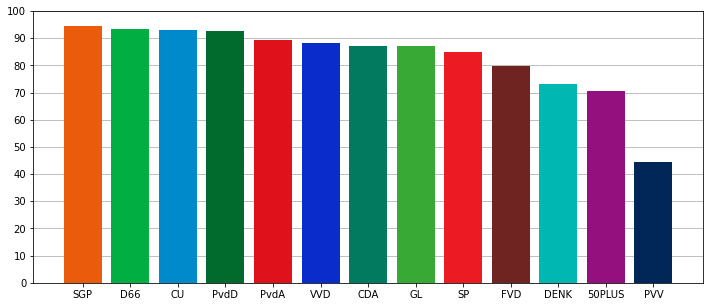

In [25]:
consistency = consistency.sort_values('Consistentie', ascending=False)
height = list(consistency['Consistentie'])
bars = tuple(consistency.index)
y_pos = np.arange(len(bars))
error = 0.1 * y_pos
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(y_pos, height, color=[party_colors_dict[party.lower()] for party in consistency.index])
plt.yticks([y * 10 for y in range(11)])
plt.xticks(y_pos, bars)
ax.set_axisbelow(True)
#ax.errorbar(bars, y_pos, yerr=error, fmt='-o')
plt.grid(axis='y')
#plt.title('Consistentie vocabulaire (t.o.v. 2017)', size = 12)
#plt.errorbar(bars, height)
plt.savefig('images/consistentie.png')
plt.show()


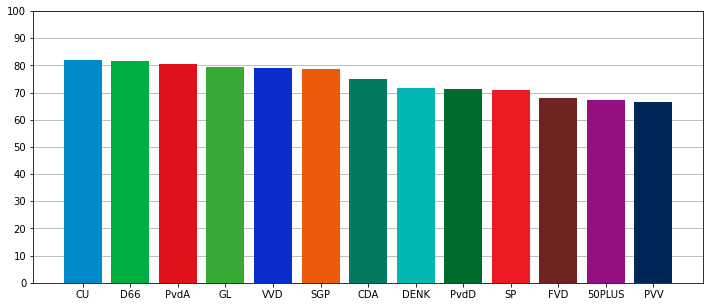

In [27]:
overeenkomsten = party_stats['Gem. overeenkomst'].sort_values(ascending=False).convert_dtypes()
height = [float(y) for y in list(overeenkomsten)]
bars = tuple(overeenkomsten.index)
y_pos = np.arange(len(bars))
error = 0.1 * y_pos
fig, ax = plt.subplots(figsize=(12,5))
plt.bar(y_pos, height, color=[party_colors_dict[party.lower()] for party in overeenkomsten.index])
plt.yticks([y * 10 for y in range(11)])
plt.xticks(y_pos, bars)
ax.set_axisbelow(True)
#ax.errorbar(bars, y_pos, yerr=error, fmt='-o')
plt.grid(axis='y')
#plt.title('Gem. overeenkomst vocabulaire met overige partijen', size = 12)
#plt.errorbar(bars, height)
plt.savefig('images/gem_overeenkomst.png')
plt.show()


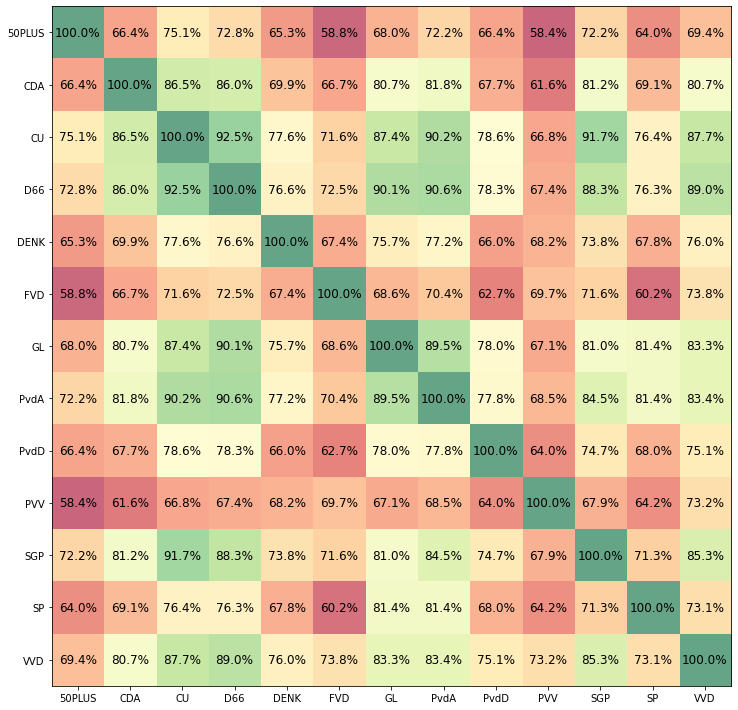

In [28]:
conf_matrix = np.array(cosy)

fig, ax = plt.subplots(figsize=(12.5, 12.5))
ax.imshow(cosy, cmap=plt.cm.RdYlGn, alpha=.6)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=str(conf_matrix[i, j].round(1)) + '%', va='center', ha='center', size='large')
        
plt.xticks(ticks = [x for x in range(conf_matrix.shape[0])], labels = list(cosy.index))
plt.yticks(ticks = [y for y in range(conf_matrix.shape[1])], labels = list(cosy.columns))
#plt.title('Mate van overeenkomstigheid \n', fontsize=18)
plt.savefig('images/mate-van-overeenkomstigheid.png')
plt.show()

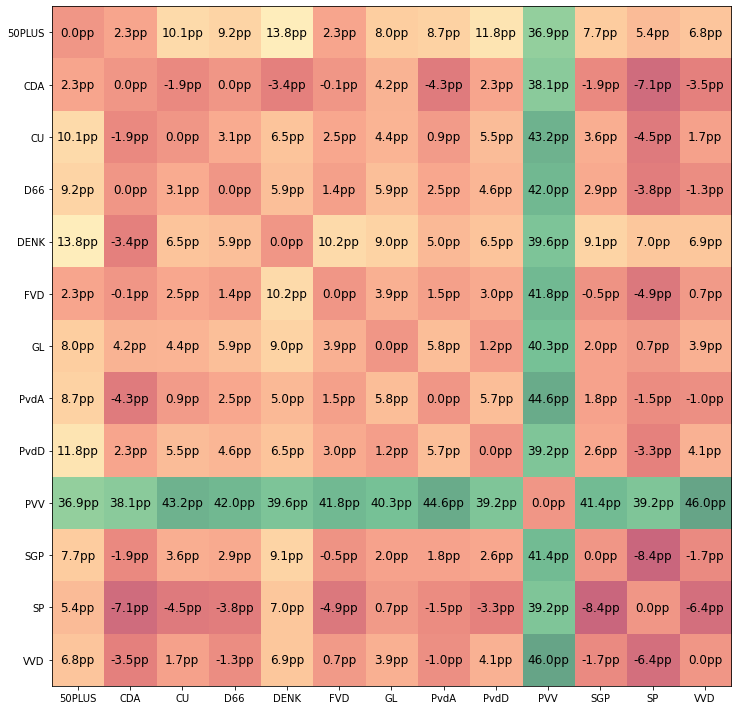

In [29]:
conf_matrix = np.array(transitions)

fig, ax = plt.subplots(figsize=(12.5, 12.5))
ax.imshow(transitions, cmap=plt.cm.RdYlGn, alpha=.6)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=str(conf_matrix[i, j].round(1)) + 'pp', va='center', ha='center', size='large')
        
plt.xticks(ticks = [x for x in range(conf_matrix.shape[0])], labels = list(cosy.index))
plt.yticks(ticks = [y for y in range(conf_matrix.shape[1])], labels = list(cosy.columns))
#plt.title('Verschuiving qua mate van overeenkomstigheid \n', fontsize=18)
plt.savefig('images/verschuiving-overeenkomstigheid.png')
plt.show()

In [30]:
simdict = {p: {'Partij' : q, 'Gelijkenis' : round(max(cosy[p].drop(p)),1)} for p in cosy.columns for q in cosy.index if max(cosy[p].drop(p)) == cosy[p][q]}

simdict2 = {p: {"Partij ('17)" : q, "Gelijkenis ('17)" : round(max(cosy_h[p].drop(p)),1)} for p in cosy_h.columns for q in cosy_h.index if max(cosy_h[p].drop(p)) == cosy_h[p][q]}

In [31]:
df1 = pd.DataFrame(simdict).T
df2 = pd.DataFrame(simdict2).T

buren = pd.concat([df1,df2], axis=1).convert_dtypes()

buren

,Partij,Gelijkenis,Partij ('17),Gelijkenis ('17)
50PLUS,CU,75.1,CU,65.0
CDA,CU,86.5,CU,88.4
CU,D66,92.5,D66,89.4
D66,CU,92.5,VVD,90.3
DENK,CU,77.6,CDA,73.3
FVD,VVD,73.8,VVD,73.1
GL,D66,90.1,D66,84.2
PvdA,D66,90.6,CU,89.3
PvdD,CU,78.6,GL,76.8
PVV,VVD,73.2,DENK,28.6


In [32]:
buren.to_latex('results/tex/buren.tex', decimal = ',')

In [33]:
#avg cosine sim

round(np.mean(np.mean([cosy[party].drop(party) for party in cosy.index])), 2)

74.77

In [34]:
#std. cosine sim

np.std(np.array([cosy[party].drop(party) for party in cosy.index]))

8.608115924133084

In [35]:
np.median(transitions)

3.0000000000000067

In [36]:
t = transitions.drop('PVV').drop('PVV', axis=1)

In [37]:
round(np.mean(np.array([transitions[party].drop(party) for party in transitions.index])),2)

8.56

In [38]:
round(np.mean(np.array([t[party].drop(party) for party in t.index])), 2)

2.65

In [39]:
np.mean(transitions['PVV'])

37.86923076923077